In [1]:
import keras
import tensorflow as tf

In [2]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
# training data
base_dir = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\train')
mask_dir = base_dir.joinpath('mask')
train_image_dir = mask_dir.joinpath('u_train_reproject')
trees_mask_dir = mask_dir.joinpath('trees')
building_mask_dir = mask_dir.joinpath('building')
pavement_mask_dir = mask_dir.joinpath('pavement')

In [ ]:
# alter unet code from package
from keras_unet import TF
if TF:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )
else:    
    from keras.models import Model
    from keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )


def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet2(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (5,5)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
I, N, M = 60, 256, 256

In [30]:
os.listdir(mask_dir)

['building', 'desktop.ini', 'pavement', 'trees', 'u_train_reproject']

In [31]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [32]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [33]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[6:-7,6:-6]

def load_image_no_trim(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [34]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [35]:
def load_stack_safely(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [36]:
def load_stack_nt(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape=shape, dtype=dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image_no_trim(image_path)
    return stack

In [37]:
train_images = load_stack_safely((I, N, M), np.float32, train_image_dir, "wgs_train")
tree_masks = load_stack_safely((I, N, M), np.int8, trees_mask_dir, "tree_mask")
building_masks = load_stack_safely((I, N, M), np.int8, building_mask_dir, "building_mask")
pavement_masks = load_stack_safely((I, N, M), np.int8, pavement_mask_dir, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_27.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_31.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_34.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_51.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\train\ma

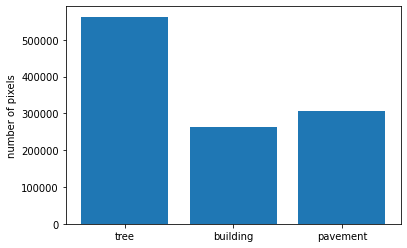

In [38]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

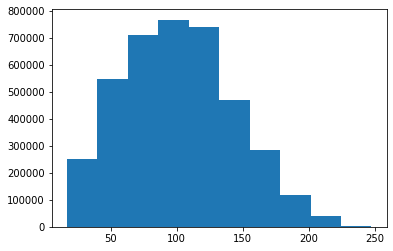

In [39]:
plt.hist(train_images.flatten())
plt.show()

In [56]:
model = satellite_unet2(
    (N, M, 1),
    3,
    # dropout_type="spatial"
)

In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded],
    
)

In [58]:
Y = np.zeros(shape=(I, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [59]:
Y.shape, tree_masks.shape

((60, 256, 256, 3), (60, 256, 256))

In [60]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_146 (Conv2D)            (None, 256, 256, 64  5248        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_158 (Batch  (None, 256, 256, 64  256        ['conv2d_146[0][0]']             
 Normalization)                 )                                                           

In [61]:
checkpoint_path = Path(r'e:\Google Drive\research\projects\utica\model_save\model_kernal\check')
checkpoint_dir = os.path.dirname(checkpoint_path)

In [62]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [63]:
history = model.fit(
    train_images.reshape(I, N, M, 1),
    Y,
    epochs=300,
          callbacks=[cp_callback])

Epoch 1/300
2/2 [==============================] - ETA: 0s - loss: 1.7145 - iou: 0.1006 - iou_thresholded: 0.0995  
Epoch 00001: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 167s 77s/step - loss: 1.7145 - iou: 0.1006 - iou_thresholded: 0.0995
Epoch 2/300
2/2 [==============================] - ETA: 0s - loss: 1.7178 - iou: 0.1056 - iou_thresholded: 0.1075  
Epoch 00002: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 164s 77s/step - loss: 1.7178 - iou: 0.1056 - iou_thresholded: 0.1075
Epoch 3/300
2/2 [==============================] - ETA: 0s - loss: 0.4782 - iou: 0.1391 - iou_thresholded: 0.1732  
Epoch 00003: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 164s 77s/step - loss: 0.4782 - iou: 0.1391 - iou_thresholded: 0.1732
Epoch 4/300
2/2 [==============

2/2 [==============================] - ETA: 0s - loss: 0.2519 - iou: 0.1731 - iou_thresholded: 0.1904  
Epoch 00026: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 160s 75s/step - loss: 0.2519 - iou: 0.1731 - iou_thresholded: 0.1904
Epoch 27/300
2/2 [==============================] - ETA: 0s - loss: 0.2407 - iou: 0.1614 - iou_thresholded: 0.1616  
Epoch 00027: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 160s 75s/step - loss: 0.2407 - iou: 0.1614 - iou_thresholded: 0.1616
Epoch 28/300
2/2 [==============================] - ETA: 0s - loss: 0.2445 - iou: 0.1731 - iou_thresholded: 0.1980  
Epoch 00028: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 159s 75s/step - loss: 0.2445 - iou: 0.1731 - iou_thresholded: 0.1980
Epoch 29/300
2/2 [=======================

2/2 [==============================] - ETA: 0s - loss: 0.2137 - iou: 0.2431 - iou_thresholded: 0.3044  
Epoch 00051: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 161s 76s/step - loss: 0.2137 - iou: 0.2431 - iou_thresholded: 0.3044
Epoch 52/300
2/2 [==============================] - ETA: 0s - loss: 0.2163 - iou: 0.2342 - iou_thresholded: 0.2918  
Epoch 00052: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 161s 76s/step - loss: 0.2163 - iou: 0.2342 - iou_thresholded: 0.2918
Epoch 53/300
2/2 [==============================] - ETA: 0s - loss: 0.2207 - iou: 0.2227 - iou_thresholded: 0.2633  
Epoch 00053: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 161s 76s/step - loss: 0.2207 - iou: 0.2227 - iou_thresholded: 0.2633
Epoch 54/300
2/2 [=======================

2/2 [==============================] - ETA: 0s - loss: 0.1928 - iou: 0.2614 - iou_thresholded: 0.3483  
Epoch 00076: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 160s 76s/step - loss: 0.1928 - iou: 0.2614 - iou_thresholded: 0.3483
Epoch 77/300
2/2 [==============================] - ETA: 0s - loss: 0.1925 - iou: 0.2697 - iou_thresholded: 0.3499  
Epoch 00077: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 163s 78s/step - loss: 0.1925 - iou: 0.2697 - iou_thresholded: 0.3499
Epoch 78/300
2/2 [==============================] - ETA: 0s - loss: 0.1902 - iou: 0.2843 - iou_thresholded: 0.3609  
Epoch 00078: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 163s 77s/step - loss: 0.1902 - iou: 0.2843 - iou_thresholded: 0.3609
Epoch 79/300
2/2 [=======================

2/2 [==============================] - ETA: 0s - loss: 0.1645 - iou: 0.3159 - iou_thresholded: 0.4104  
Epoch 00101: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 163s 77s/step - loss: 0.1645 - iou: 0.3159 - iou_thresholded: 0.4104
Epoch 102/300
2/2 [==============================] - ETA: 0s - loss: 0.1806 - iou: 0.3092 - iou_thresholded: 0.3737  
Epoch 00102: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 163s 77s/step - loss: 0.1806 - iou: 0.3092 - iou_thresholded: 0.3737
Epoch 103/300
2/2 [==============================] - ETA: 0s - loss: 0.1873 - iou: 0.3296 - iou_thresholded: 0.4271  
Epoch 00103: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 163s 77s/step - loss: 0.1873 - iou: 0.3296 - iou_thresholded: 0.4271
Epoch 104/300
2/2 [====================

2/2 [==============================] - ETA: 0s - loss: 0.1611 - iou: 0.3386 - iou_thresholded: 0.4434  
Epoch 00126: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 162s 76s/step - loss: 0.1611 - iou: 0.3386 - iou_thresholded: 0.4434
Epoch 127/300
2/2 [==============================] - ETA: 0s - loss: 0.1654 - iou: 0.3376 - iou_thresholded: 0.4308  
Epoch 00127: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 74s/step - loss: 0.1654 - iou: 0.3376 - iou_thresholded: 0.4308
Epoch 128/300
2/2 [==============================] - ETA: 0s - loss: 0.1564 - iou: 0.3545 - iou_thresholded: 0.4440  
Epoch 00128: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 74s/step - loss: 0.1564 - iou: 0.3545 - iou_thresholded: 0.4440
Epoch 129/300
2/2 [====================

2/2 [==============================] - ETA: 0s - loss: 0.1467 - iou: 0.3740 - iou_thresholded: 0.4525  
Epoch 00151: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 75s/step - loss: 0.1467 - iou: 0.3740 - iou_thresholded: 0.4525
Epoch 152/300
2/2 [==============================] - ETA: 0s - loss: 0.1385 - iou: 0.4012 - iou_thresholded: 0.5119  
Epoch 00152: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 159s 75s/step - loss: 0.1385 - iou: 0.4012 - iou_thresholded: 0.5119
Epoch 153/300
2/2 [==============================] - ETA: 0s - loss: 0.1385 - iou: 0.4177 - iou_thresholded: 0.5329  
Epoch 00153: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 159s 75s/step - loss: 0.1385 - iou: 0.4177 - iou_thresholded: 0.5329
Epoch 154/300
2/2 [====================

2/2 [==============================] - ETA: 0s - loss: 0.1272 - iou: 0.4383 - iou_thresholded: 0.5523  
Epoch 00176: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 74s/step - loss: 0.1272 - iou: 0.4383 - iou_thresholded: 0.5523
Epoch 177/300
2/2 [==============================] - ETA: 0s - loss: 0.1264 - iou: 0.4371 - iou_thresholded: 0.5432  
Epoch 00177: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 157s 74s/step - loss: 0.1264 - iou: 0.4371 - iou_thresholded: 0.5432
Epoch 178/300
2/2 [==============================] - ETA: 0s - loss: 0.1240 - iou: 0.4377 - iou_thresholded: 0.5463  
Epoch 00178: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 160s 75s/step - loss: 0.1240 - iou: 0.4377 - iou_thresholded: 0.5463
Epoch 179/300
2/2 [====================

2/2 [==============================] - ETA: 0s - loss: 0.1138 - iou: 0.4731 - iou_thresholded: 0.5890  
Epoch 00201: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 75s/step - loss: 0.1138 - iou: 0.4731 - iou_thresholded: 0.5890
Epoch 202/300
2/2 [==============================] - ETA: 0s - loss: 0.1190 - iou: 0.4690 - iou_thresholded: 0.5751  
Epoch 00202: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 75s/step - loss: 0.1190 - iou: 0.4690 - iou_thresholded: 0.5751
Epoch 203/300
2/2 [==============================] - ETA: 0s - loss: 0.1116 - iou: 0.4749 - iou_thresholded: 0.5811  
Epoch 00203: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 75s/step - loss: 0.1116 - iou: 0.4749 - iou_thresholded: 0.5811
Epoch 204/300
2/2 [====================

2/2 [==============================] - ETA: 0s - loss: 0.1013 - iou: 0.5144 - iou_thresholded: 0.6207  
Epoch 00226: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 162s 76s/step - loss: 0.1013 - iou: 0.5144 - iou_thresholded: 0.6207
Epoch 227/300
2/2 [==============================] - ETA: 0s - loss: 0.0973 - iou: 0.5278 - iou_thresholded: 0.6397  
Epoch 00227: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 162s 76s/step - loss: 0.0973 - iou: 0.5278 - iou_thresholded: 0.6397
Epoch 228/300
2/2 [==============================] - ETA: 0s - loss: 0.0983 - iou: 0.5296 - iou_thresholded: 0.6360  
Epoch 00228: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 163s 77s/step - loss: 0.0983 - iou: 0.5296 - iou_thresholded: 0.6360
Epoch 229/300
2/2 [====================

2/2 [==============================] - ETA: 0s - loss: 0.0959 - iou: 0.5407 - iou_thresholded: 0.6511  
Epoch 00251: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 163s 77s/step - loss: 0.0959 - iou: 0.5407 - iou_thresholded: 0.6511
Epoch 252/300
2/2 [==============================] - ETA: 0s - loss: 0.0967 - iou: 0.5378 - iou_thresholded: 0.6436  
Epoch 00252: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 159s 75s/step - loss: 0.0967 - iou: 0.5378 - iou_thresholded: 0.6436
Epoch 253/300
2/2 [==============================] - ETA: 0s - loss: 0.0972 - iou: 0.5385 - iou_thresholded: 0.6324  
Epoch 00253: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 158s 75s/step - loss: 0.0972 - iou: 0.5385 - iou_thresholded: 0.6324
Epoch 254/300
2/2 [====================

2/2 [==============================] - ETA: 0s - loss: 0.0812 - iou: 0.5822 - iou_thresholded: 0.6892  
Epoch 00276: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 160s 75s/step - loss: 0.0812 - iou: 0.5822 - iou_thresholded: 0.6892
Epoch 277/300
2/2 [==============================] - ETA: 0s - loss: 0.0810 - iou: 0.6002 - iou_thresholded: 0.6971  
Epoch 00277: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 160s 76s/step - loss: 0.0810 - iou: 0.6002 - iou_thresholded: 0.6971
Epoch 278/300
2/2 [==============================] - ETA: 0s - loss: 0.0779 - iou: 0.6047 - iou_thresholded: 0.7063  
Epoch 00278: saving model to e:\Google Drive\research\projects\utica\model_save\model_kernal\check
2/2 [==============================] - 160s 75s/step - loss: 0.0779 - iou: 0.6047 - iou_thresholded: 0.7063
Epoch 279/300
2/2 [====================

In [64]:
modelsave_path = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\model_kernal\saved_model50')

In [65]:
modelsave_path

WindowsPath('e:/Google Drive/research/projects/utica/model_save/1950/model_kernal/saved_model50')

In [66]:
model.save(modelsave_path)

INFO:tensorflow:Assets written to: e:\Google Drive\research\projects\utica\model_save\1950\model_kernal\saved_model50\assets


In [67]:
Y_pred = model.predict(train_images.reshape(I, N, M, 1))

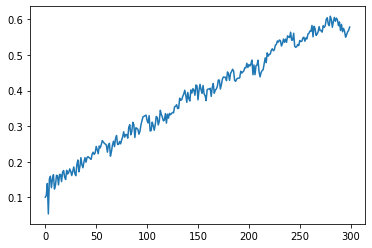

In [68]:
plt.plot(history.history['iou'])

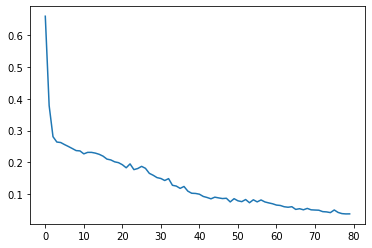

In [58]:
plt.plot(history.history['loss'])

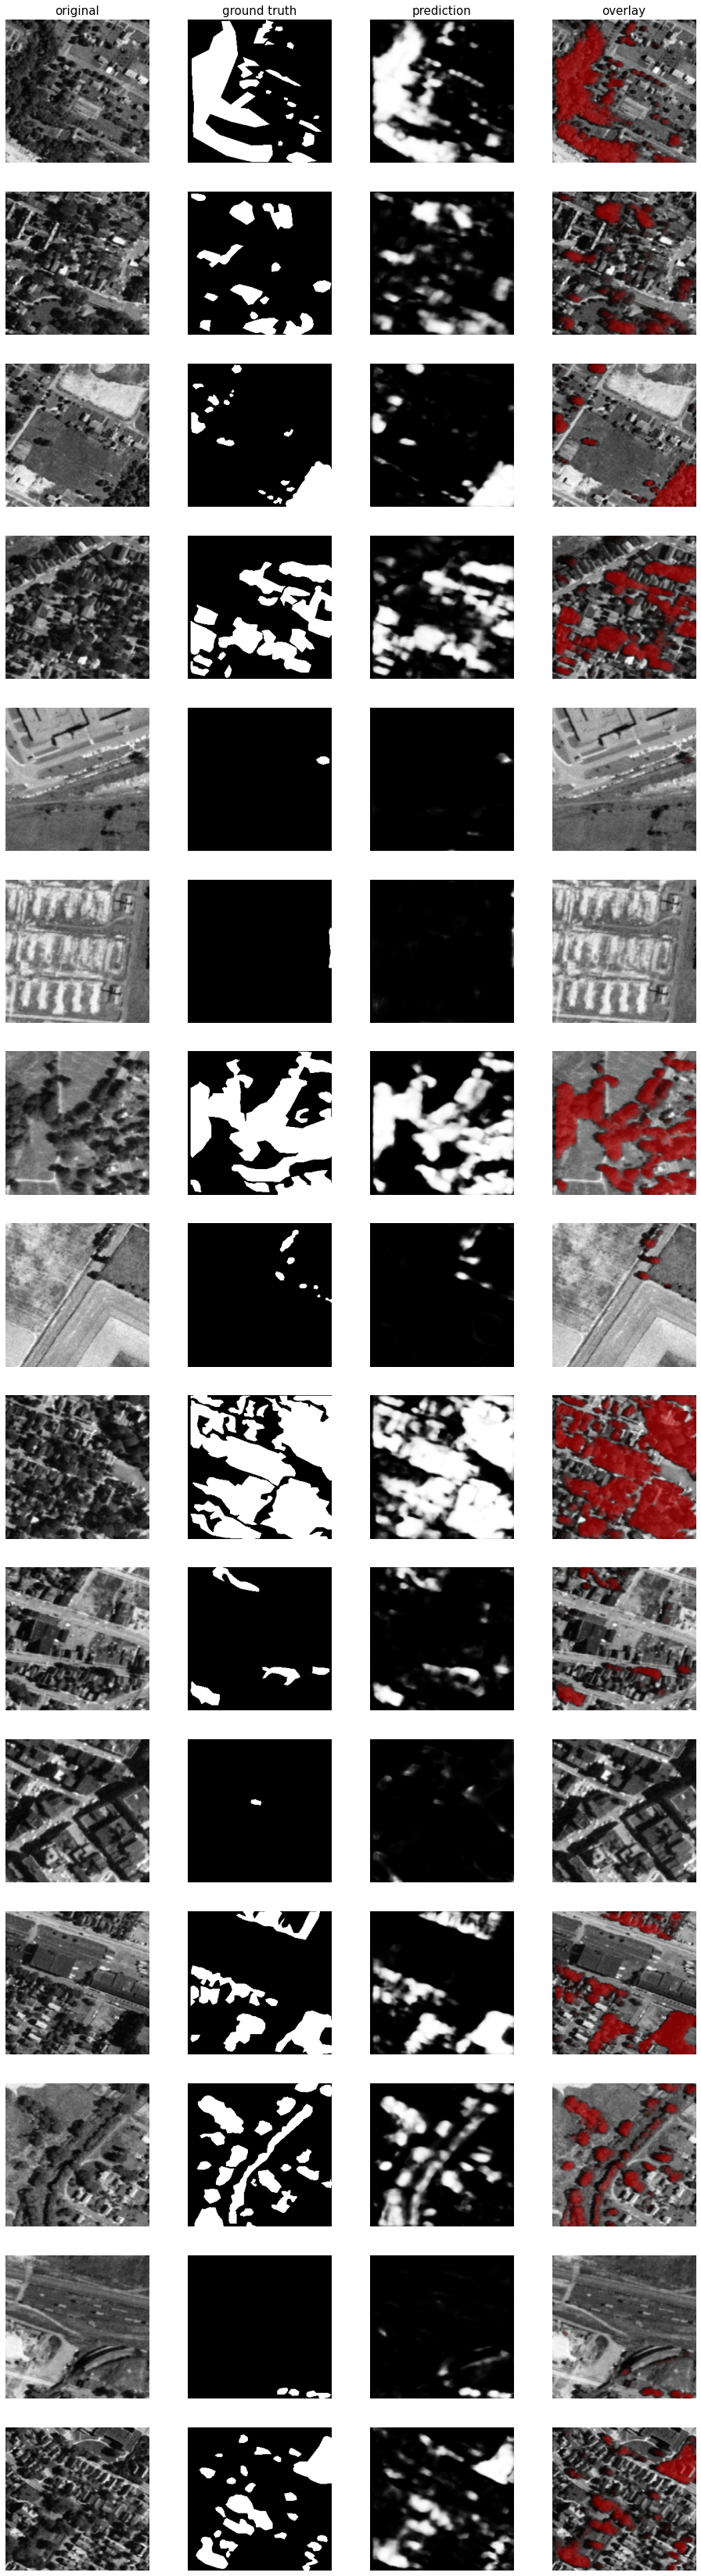

In [69]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=15
  )

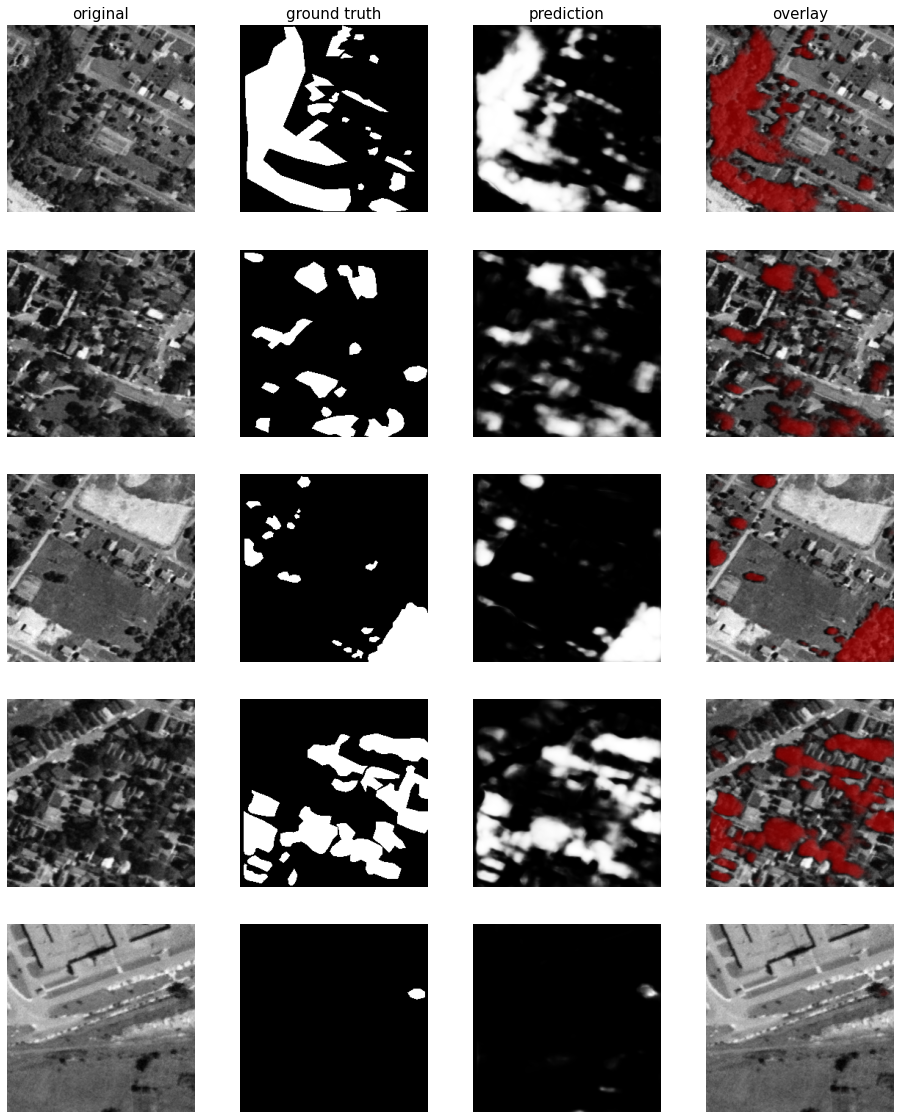

In [70]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=5
  )

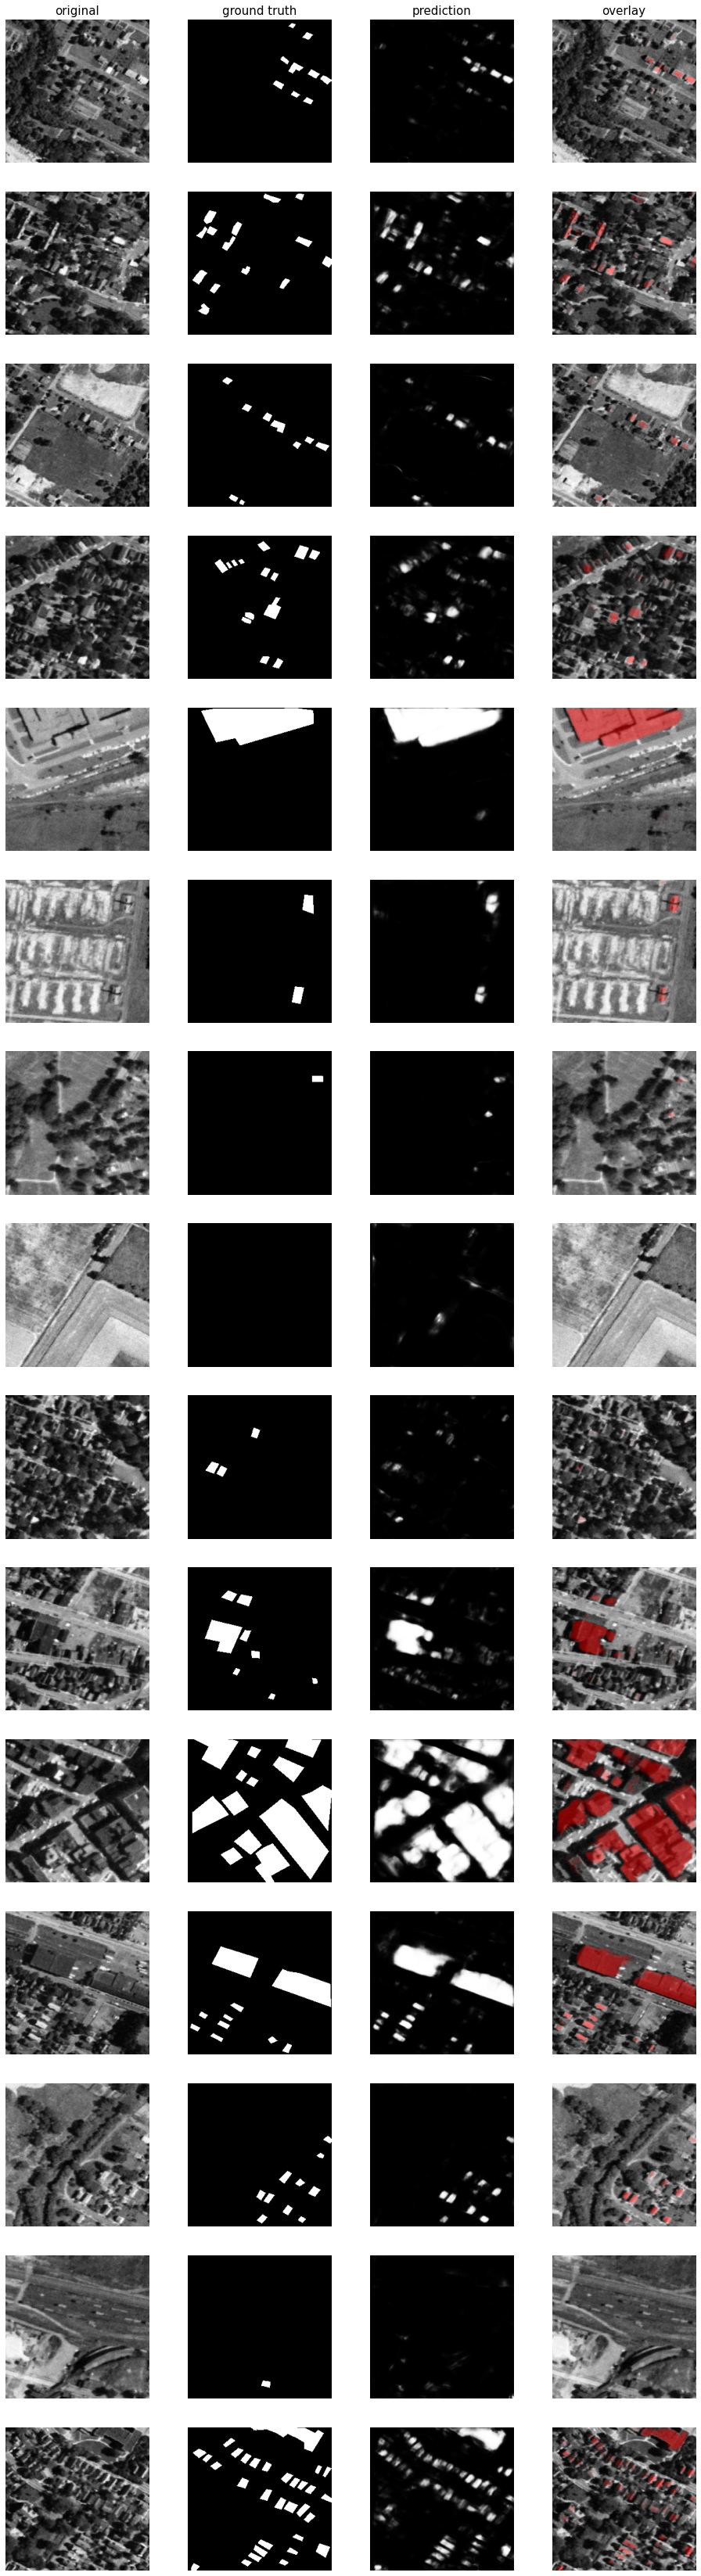

In [71]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 1], 
    pred_imgs=Y_pred[:, :, :, 1], 
    nm_img_to_plot=15
  )

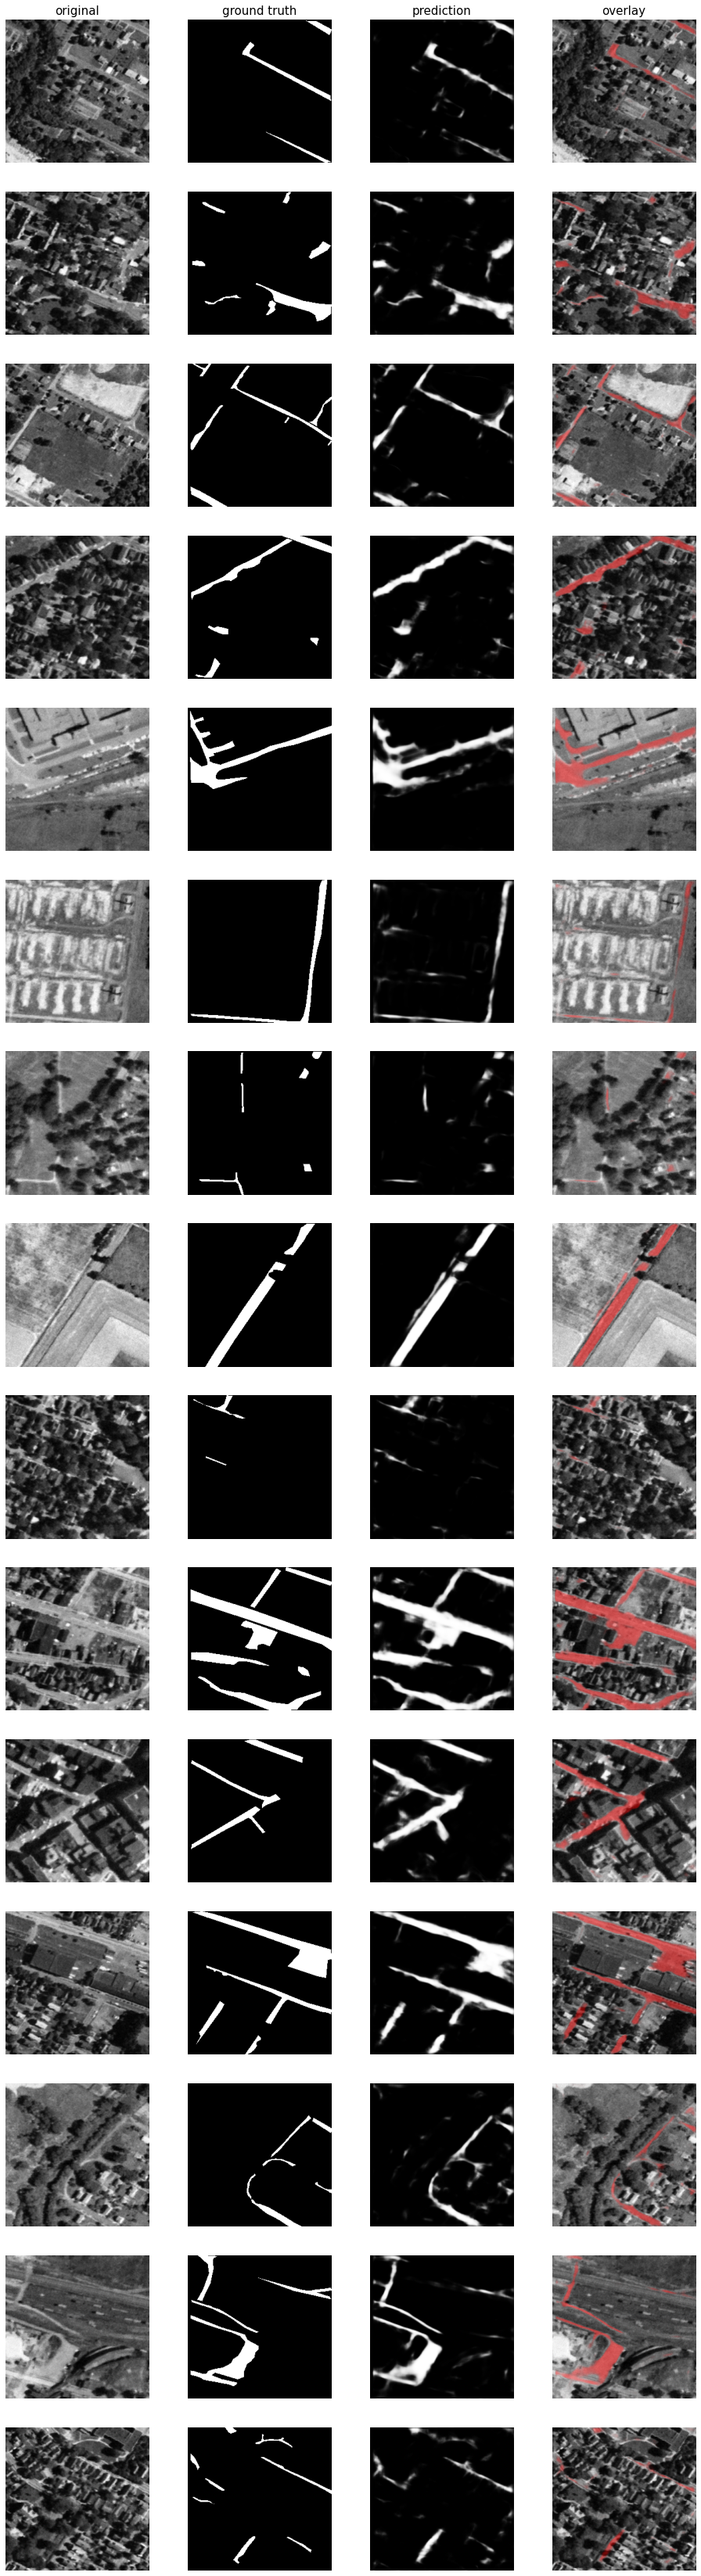

In [72]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 2], 
    pred_imgs=Y_pred[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [73]:
# validation data
base_dir = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\valid')
mask_dirV = base_dir.joinpath('mask_50s_valid')
train_image_dirV = mask_dirV.joinpath('u_valid_reproject')
trees_mask_dirV = mask_dirV.joinpath('trees')
building_mask_dirV = mask_dirV.joinpath('building')
pavement_mask_dirV = mask_dirV.joinpath('pavement')

In [74]:
K, N, M = 20, 256, 256

In [75]:
valid_images = load_stack_safely((K, N, M), np.float32, train_image_dirV, "wgs_valid")
tree_valid = load_stack_safely((K, N, M), np.int8, trees_mask_dirV, "tree_mask")
building_valid = load_stack_safely((K, N, M), np.int8, building_mask_dirV, "building_mask")
pavement_valid = load_stack_safely((K, N, M), np.int8, pavement_mask_dirV, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\valid\mask_50s_valid\building\building_mask_4.tif
skipping e:\Google Drive\research\projects\utica\model_save\1950\data_256\valid\mask_50s_valid\building\building_mask_4.tif


In [76]:
Yvalid = np.zeros(shape=(K, N, M, 3), dtype=np.int8)
Yvalid[:, :, :, 0] = tree_valid
Yvalid[:, :, :, 1] = building_valid
Yvalid[:, :, :, 2] = pavement_valid

In [77]:
Y_valid = model.predict(valid_images.reshape(K, N, M, 1))

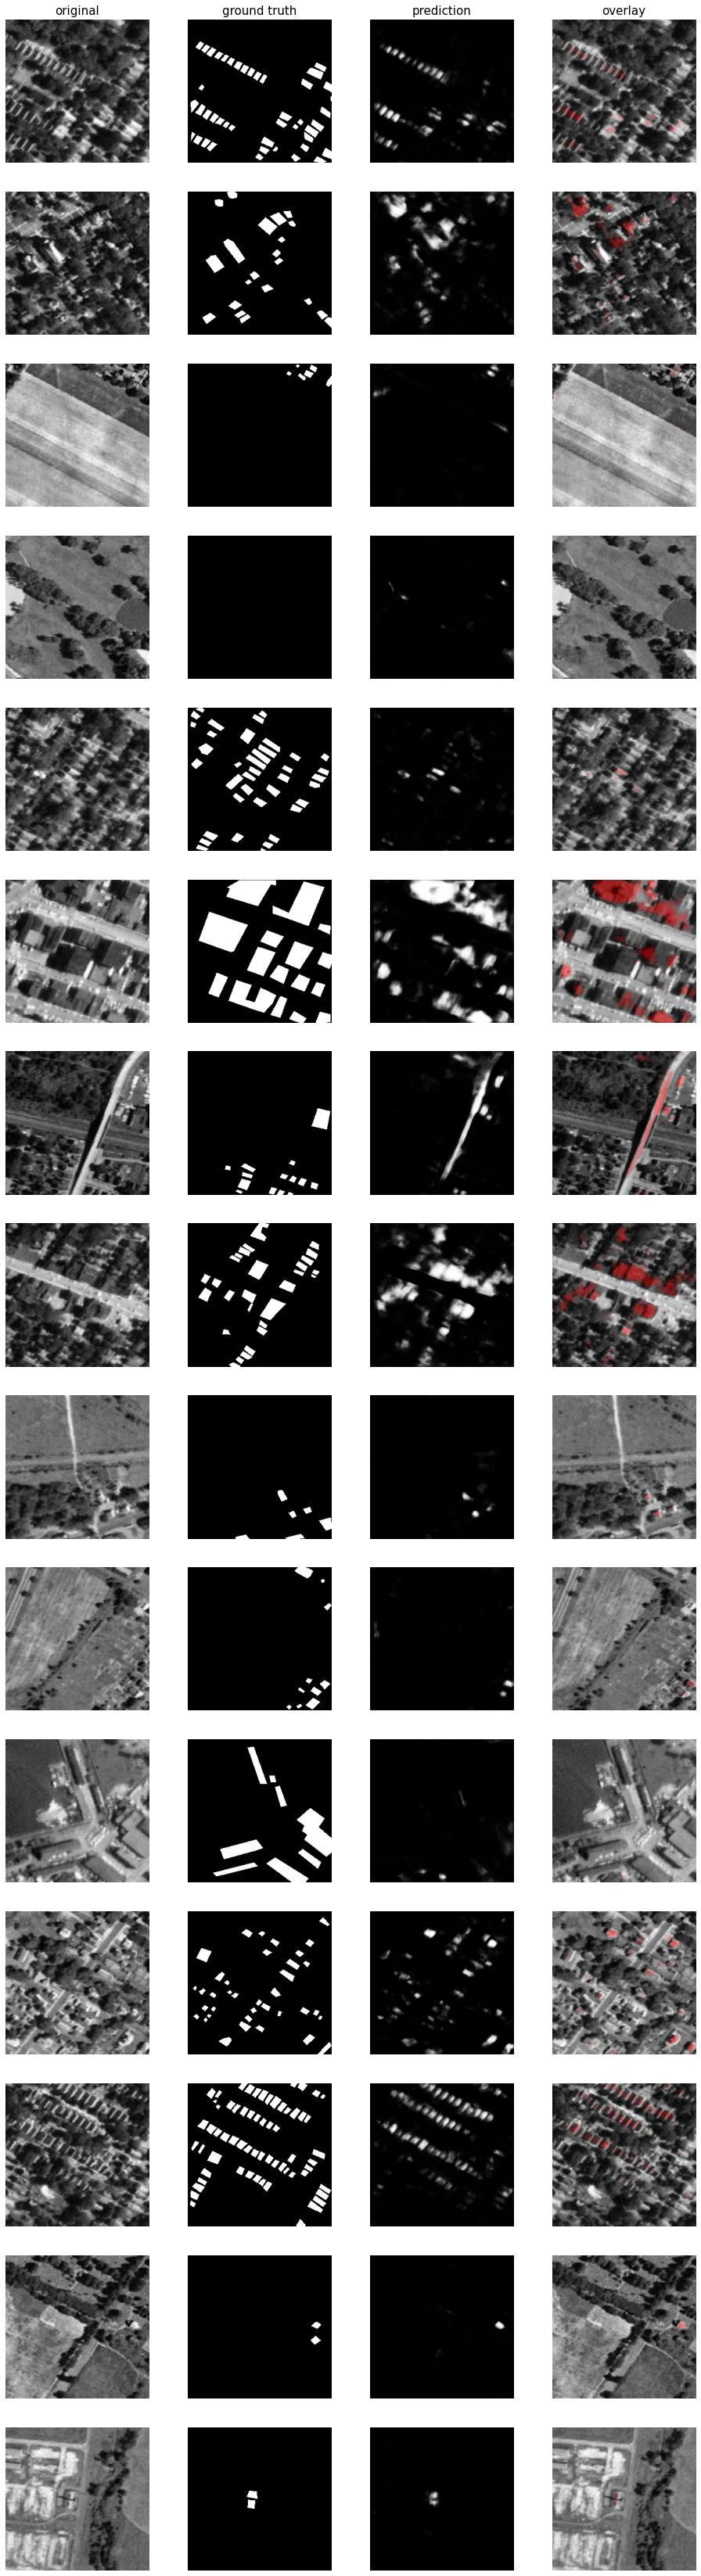

In [78]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 1], 
    pred_imgs=Y_valid[:, :, :, 1], 
    nm_img_to_plot=15
  )

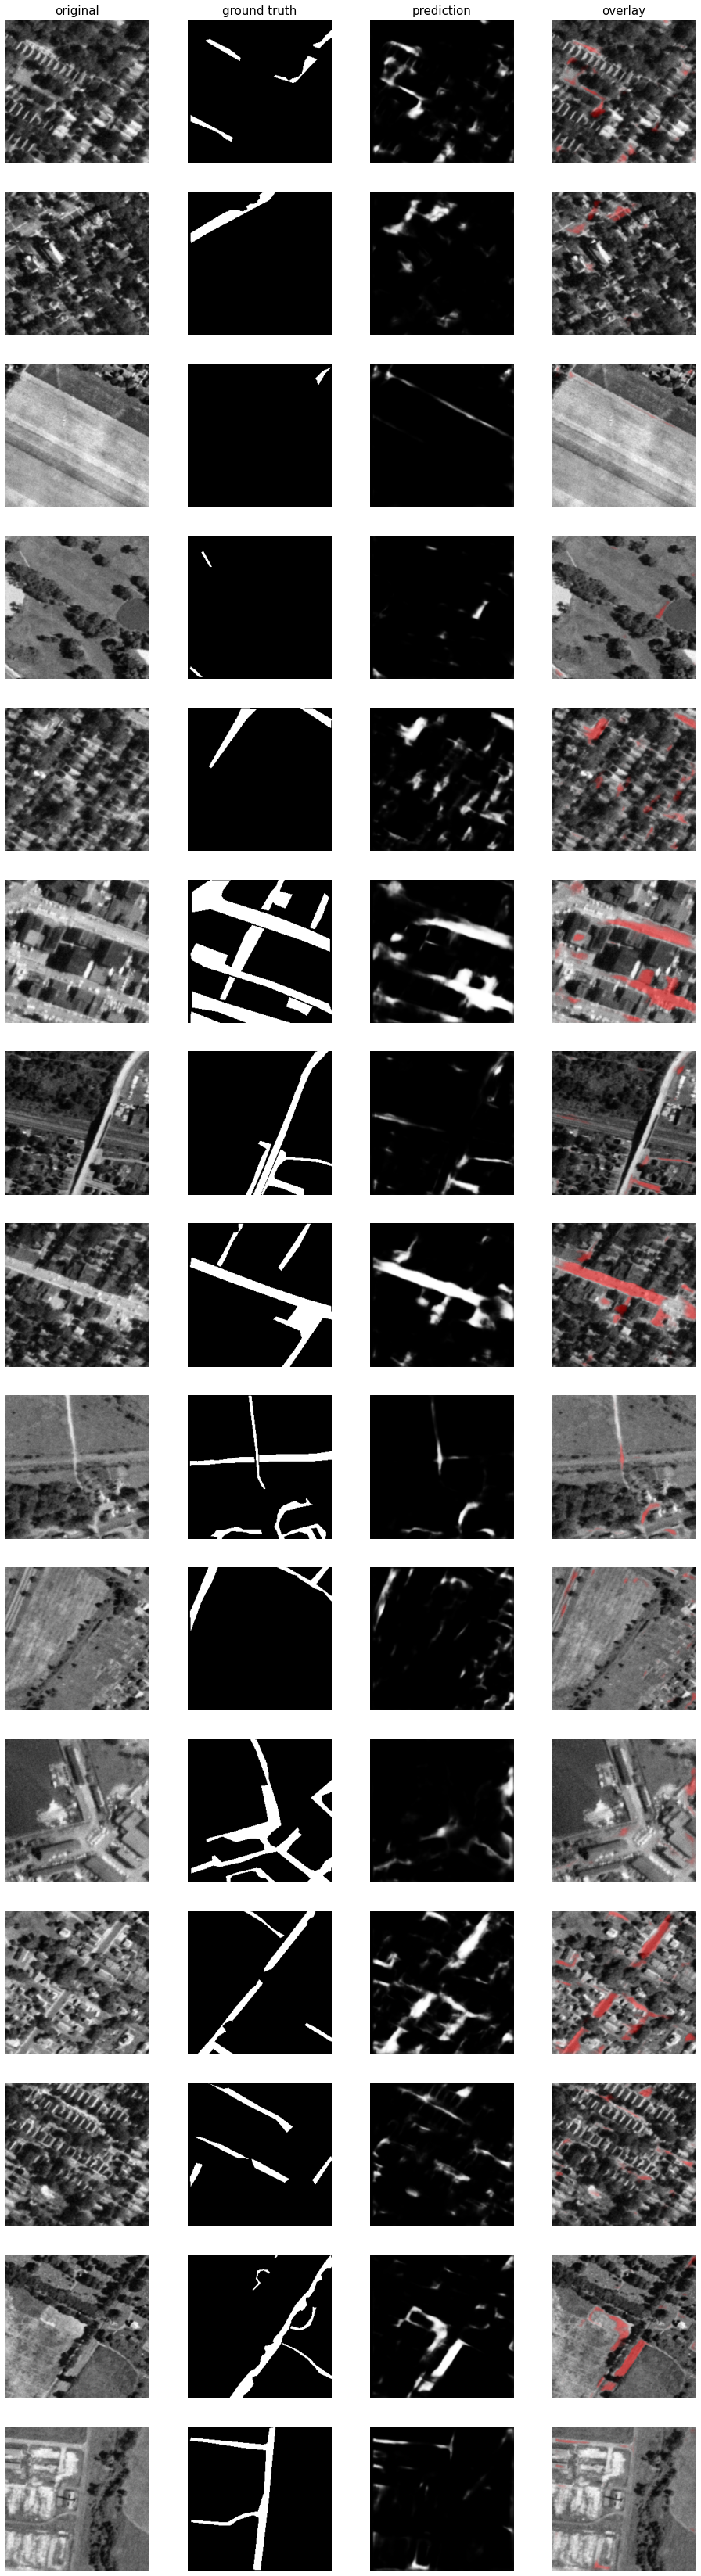

In [79]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 2], 
    pred_imgs=Y_valid[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [71]:
Y_valid[0,0,0,0]

0.01610127

In [72]:
treePredict = Y_valid[:,:,:,0]

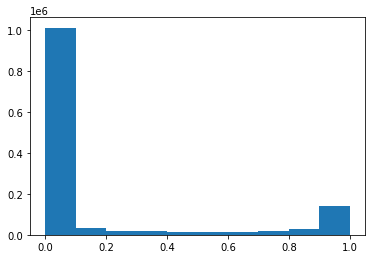

In [73]:
plt.hist(treePredict.flatten())
plt.show()

In [80]:
valid_orig = gdal.Open(r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_1.tif')

In [81]:
gt = valid_orig.GetGeoTransform()
pt = valid_orig.GetProjection()

In [82]:
# prediction data
base_dirP = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\img_tile256\predict50')

In [83]:
J, N, M = 435, 256, 256

In [84]:
predict_img = load_stack_nt((J, N, M), np.float32,base_dirP, "predict")

In [85]:
Y_all = model.predict(predict_img.reshape(J, N, M, 1))

In [86]:
Y_all.shape

(435, 256, 256, 3)

In [87]:
# prediction data offset 2 (25 pixels)
base_dirP2 = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\img_tile256\predict50_2')
predict_img2 = load_stack_nt((J, N, M), np.float32,base_dirP2, "predict")


In [ ]:
Y_all2 = model.predict(predict_img2.reshape(J, N, M, 1))

In [ ]:
Y_all2.shape

In [176]:
# prediction data offset 3 (100 pixels)
L, N, M = 392, 256, 256
base_dirP3 = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\img_tile256\predict50_3')
predict_img3 = load_stack_nt((L, N, M), np.float32,base_dirP3, "predict")

In [177]:
predict_img3.shape

(392, 256, 256)

In [178]:
Y_all3 = model.predict(predict_img3.reshape(L, N, M, 1))
Y_all3.shape

(392, 256, 256, 3)

In [101]:
driver = gdal.GetDriverByName("GTiff")

In [102]:
driver.Register()

2

In [103]:
outds = driver.Create(r'e:\Google Drive\research\projects\utica\50s_valid_out\valid_out.tif', xsize=256,ysize=256,
                     bands=1,eType=gdal.GDT_Float32)

In [104]:
outds.SetGeoTransform(gt)

0

In [105]:
outds.SetProjection(pt)

0

In [106]:
outBand = outds.GetRasterBand(1)

In [107]:
outBand.WriteArray(Y_valid[1,:,:,0])

0

In [108]:
outBand.SetNoDataValue(np.nan)

0

In [109]:
outBand.FlushCache()

In [110]:
outBand = None
outds = None

In [111]:
make_path(img_dir, prefix, i + 1,.tif)

SyntaxError: invalid syntax (Temp/ipykernel_27860/1186116247.py, line 1)

In [ ]:
def load_stack_nt(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape=shape, dtype=dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image_no_trim(image_path)
    return stack

In [112]:
def save_predict_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTree = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTree.SetGeoTransform(gt)
        outTree.SetProjection(pt)
        outBandTree = outTree.GetRasterBand(1)
        outBandTree.WriteArray(Y_valid[i,:,:,0])
        outBandTree.SetNoDataValue(np.nan)
        outBandTree.FlushCache()
        outBandTree = None
        outTree = None

In [113]:
tree_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\valid\trees'
save_predict_valid(nImg = 20,xdim= 256, ydim= 256,img_dir = tree_valid_dir,prefix = "tree_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [114]:
def save_predict_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outBuild = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outBuild.SetGeoTransform(gt)
        outBuild.SetProjection(pt)
        outBandBuild = outBuild.GetRasterBand(1)
        outBandBuild.WriteArray(Y_valid[i,:,:,1])
        outBandBuild.SetNoDataValue(np.nan)
        outBandBuild.FlushCache()
        outBandBuild = None
        outBuild = None

In [116]:
build_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\valid\building'
save_predict_validB(nImg = 20,xdim= 256, ydim= 256,img_dir =build_valid_dir,prefix = "building_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [118]:
def save_predict_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outPave = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outPave.SetGeoTransform(gt)
        outPave.SetProjection(pt)
        outBandPave = outPave.GetRasterBand(1)
        outBandPave.WriteArray(Y_valid[i,:,:,2])
        outBandPave.SetNoDataValue(np.nan)
        outBandPave.FlushCache()
        outBandPave = None
        outPave = None

In [119]:
pave_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\valid\pavement'
save_predict_validP(nImg = 20,xdim= 256, ydim= 256,img_dir =pave_valid_dir,prefix = "pavement_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [121]:
#due to late night coding, mask files where slightly off dimensions. Need to resave files that were cut down here for easier matching.
def save_mask_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [122]:
tree_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\crop_valid\tree'
save_mask_valid(nImg = 20,xdim= 256, ydim= 256,img_dir = tree_m_dir, prefix = "tree_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [124]:
def save_mask_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [125]:
build_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\crop_valid\building'
save_mask_validB(nImg = 20,xdim= 256, ydim= 256,img_dir = build_m_dir, prefix = "building_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [126]:
def save_mask_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [127]:
pave_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\crop_valid\pavement'
save_mask_validP(nImg = 20,xdim= 256, ydim= 256,img_dir = pave_m_dir, prefix = "pavement_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [129]:
def save_mask_image( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(valid_images[i, :, :])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [130]:
image_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\crop_valid\image'
save_mask_image(nImg = 20,xdim= 256, ydim= 256,img_dir = image_m_dir, prefix = "image",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [131]:
valid_images.shape

(20, 256, 256)

In [132]:
train_image_dirV

WindowsPath('e:/Google Drive/research/projects/utica/model_save/1950/data_256/valid/mask_50s_valid/u_valid_reproject')

In [133]:
# save map prediction

def save_predict_build( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


In [134]:
predict_build_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image\building'
save_predict_build(nImg = 435,xdim= 256, ydim= 256,img_dir = predict_build_dir, prefix = "building",orig_dir = base_dirP , prefix_orig = "predict")

In [179]:
# save map prediction

def save_predict_build2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


In [180]:
predict_build_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image_2\building'
save_predict_build2(nImg = 435,xdim= 256, ydim= 256,img_dir = predict_build_dir2, prefix = "building",orig_dir = base_dirP2 , prefix_orig = "predict")

In [181]:
def save_predict_build3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [182]:
predict_build_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image_3\building'
save_predict_build3(nImg = 392,xdim= 256, ydim= 256,img_dir = predict_build_dir3, prefix = "building",orig_dir = base_dirP3 , prefix_orig = "predict")

In [135]:
def save_predict_tree( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [136]:
predict_tree_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image\tree'
save_predict_tree(nImg = 435,xdim= 256, ydim= 256,img_dir = predict_tree_dir, prefix = "tree",orig_dir = base_dirP , prefix_orig = "predict")

In [183]:
def save_predict_tree2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [184]:
predict_tree_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image_2\tree'
save_predict_tree2(nImg = 435,xdim= 256, ydim= 256,img_dir = predict_tree_dir2, prefix = "tree",orig_dir = base_dirP2 , prefix_orig = "predict")

In [185]:
def save_predict_tree3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [186]:
predict_tree_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image_3\tree'
save_predict_tree3(nImg = 392,xdim= 256, ydim= 256,img_dir = predict_tree_dir3, prefix = "tree",orig_dir = base_dirP3 , prefix_orig = "predict")

In [137]:
def save_predict_pave( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [138]:
predict_pave_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image\pavement'
save_predict_pave(nImg = 435,xdim= 256, ydim= 256,img_dir = predict_pave_dir, prefix = "pavement",orig_dir = base_dirP , prefix_orig = "predict")

In [187]:
def save_predict_pave2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [188]:
predict_pave_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image_2\pavement'
save_predict_pave(nImg = 435,xdim= 256, ydim= 256,img_dir = predict_pave_dir2, prefix = "pavement",orig_dir = base_dirP2 , prefix_orig = "predict")

In [189]:
def save_predict_pave3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [190]:
predict_pave_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_256\image_3\pavement'
save_predict_pave(nImg = 392,xdim= 256, ydim= 256,img_dir = predict_pave_dir3, prefix = "pavement",orig_dir = base_dirP3 , prefix_orig = "predict")